In [51]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [53]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [54]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [55]:
tf.keras.backend.clear_session()

In [56]:
subject = 'Espírito Santo - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [57]:
data = pd.read_csv('2003_mo_model_input_ES.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - Consumo de Cimento (t),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,2003-1,8.177444,0.760059,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,48.426,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445
1,2003-2,8.171622,0.760222,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,54.969,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512
2,2003-3,8.165799,0.760385,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,53.847,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941
3,2003-4,8.159977,0.760548,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,50.375,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321
4,2003-5,8.154154,0.760710,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,52.576,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36954.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36937.748495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36867.947370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36784.826883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


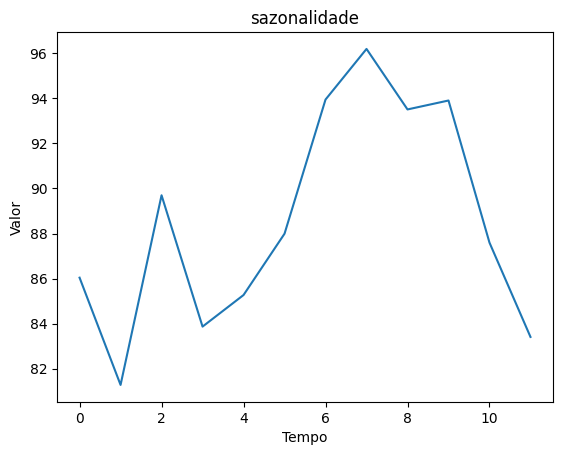

,sazonalidade
sazonalidade,
0,86.040331
1,81.281295
2,89.696422
3,83.869142
4,85.270725
5,87.991784
6,93.944169
7,96.190847
8,93.505708


In [58]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [59]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade,Espírito Santo - Consumo de Cimento (t)
0,2003-1,8.177444,0.760059,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445,86.040331,48.426
1,2003-2,8.171622,0.760222,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512,81.281295,54.969
2,2003-3,8.165799,0.760385,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941,89.696422,53.847
3,2003-4,8.159977,0.760548,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321,83.869142,50.375
4,2003-5,8.154154,0.760710,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453,85.270725,52.576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36954.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.270725,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36937.748495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.991784,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36867.947370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.944169,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36784.826883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.190847,NaN


In [60]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      56.490
1      53.578
2      60.481
3      64.833
4      64.063
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Espírito Santo - Consumo de Cimento (t), Length: 249, dtype: float64

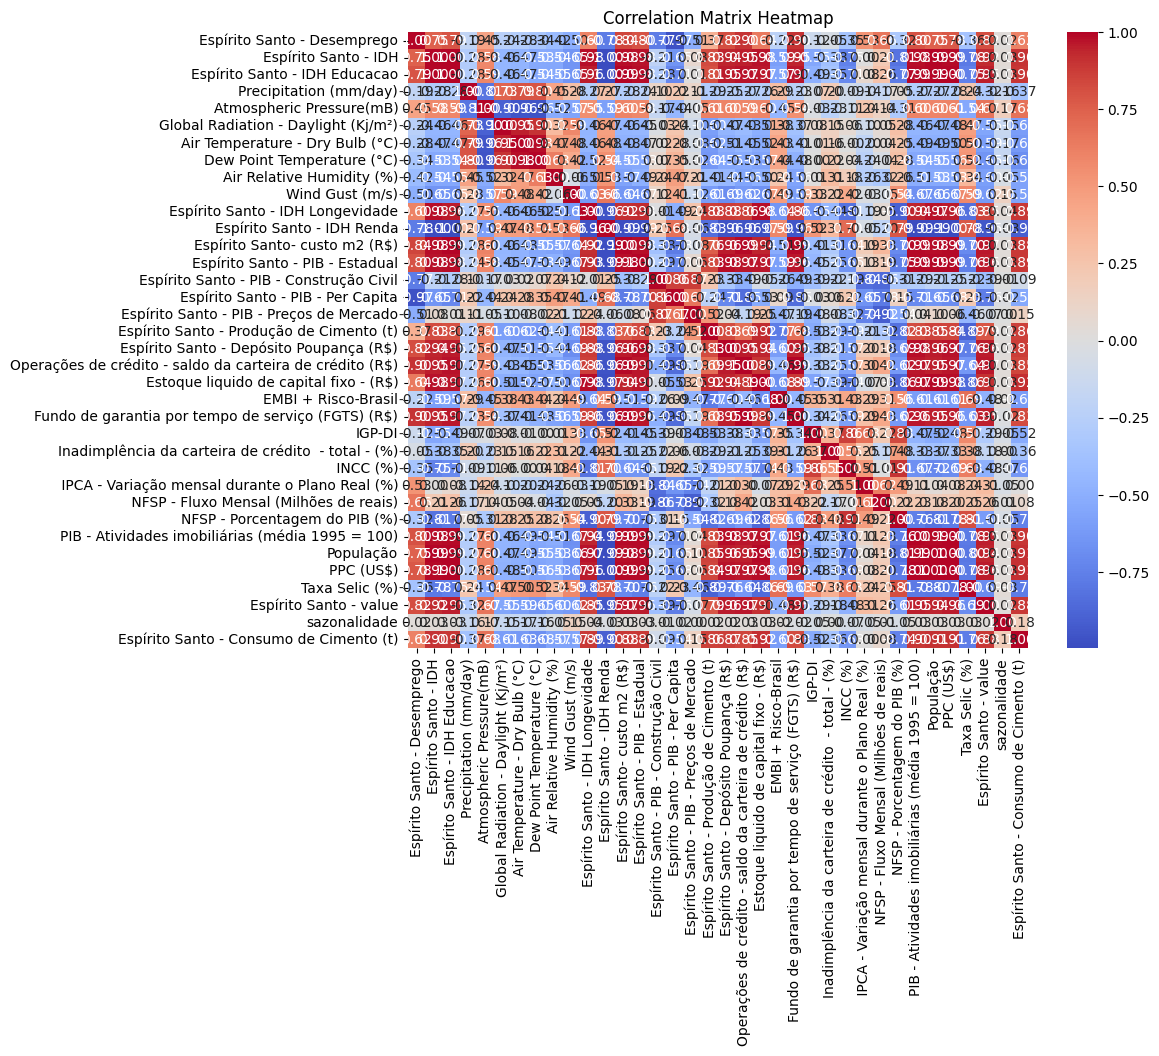

In [61]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [63]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Espírito Santo - Desemprego,5.105147e+04
1,Espírito Santo - IDH,9.039561e+10
2,Espírito Santo - IDH Educacao,4.581094e+07
3,Precipitation (mm/day),1.382050e+01
4,Atmospheric Pressure(mB),1.746458e+02
5,Global Radiation - Daylight (Kj/m²),1.066420e+02
6,Air Temperature - Dry Bulb (°C),4.013059e+04
7,Dew Point Temperature (°C),5.145496e+04
8,Air Relative Humidity (%),2.295150e+03
9,Wind Gust (m/s),3.503238e+01


In [64]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 3


,Espírito Santo - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade
0,8.177444,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,98.171240,4.069229e+06,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445,86.040331
1,8.171622,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,97.897317,4.094341e+06,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512,81.281295
2,8.165799,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,98.070539,4.119454e+06,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941,89.696422
3,8.159977,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,98.460789,4.144566e+06,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321,83.869142
4,8.154154,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,99.084134,4.169679e+06,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453,85.270725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,10.963739,1.150666,1017.111299,1351.791139,24.278694,19.039434,74.494690,1.869993,0.874582,0.733454,22656.138645,7.228383e+07,3.493148e+06,16.456776,159.207486,7.914203e+06,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,0.368156,96.190847
152,10.966837,1.342083,1016.048854,1441.498777,25.136205,19.587231,73.179160,2.013497,0.875553,0.732946,22756.902370,7.229955e+07,3.491596e+06,16.453880,157.516710,7.866752e+06,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,0.368278,93.505708
153,10.969935,1.495502,1015.189309,1482.429136,25.629353,20.094206,73.284786,2.015842,0.876525,0.732438,22854.485707,7.231526e+07,3.490044e+06,16.450984,155.924455,7.819300e+06,3.177292e+06,7.822521e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,1.971270e+08,393.032398,1.138989,0.368393,93.901743
154,10.973033,1.610481,1014.428930,1568.511409,26.318460,20.623451,72.761887,2.019370,0.877497,0.731930,22952.869036,7.233098e+07,3.488492

In [65]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,-0.646634,0.124441,-0.209825,-0.401386,-0.373094,-0.130061,1.208968,-2.406926,1.877706,-1.579421,-1.778746,-1.393481,-0.249635,-1.717076,-1.493086,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,-1.103809
1,-0.645365,0.125813,-0.210832,-0.401776,-0.373606,-0.130768,1.202907,-2.355207,1.849223,-1.553163,-1.749882,-1.335998,-0.203501,-1.724270,-1.477208,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,-1.053016
2,-0.644625,0.126614,-0.211419,-0.402004,-0.373905,-0.131181,1.199371,-2.303488,1.820741,-1.527661,-1.721018,-1.278515,-0.157368,-1.719721,-1.461329,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,-1.017877
3,-0.644546,0.126700,-0.211482,-0.402028,-0.373937,-0.131225,1.198992,-2.251769,1.792258,-1.502751,-1.692154,-1.221031,-0.111234,-1.709472,-1.445451,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,-0.983973
4,-0.602575,0.094437,-0.186532,-0.365491,-0.336351,-0.106422,1.199879,-2.200050,1.763775,-1.478293,-1.663290,-1.163548,-0.065101,-1.693101,-1.429572,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,-0.956152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,-1.883855,0.970323,-0.685469,-0.461576,-0.714236,-1.402494,-0.499176,1.484303,-1.579796,1.738210,1.302963,-1.910980,-2.202973,-0.114117,0.938040,1.823582,0.951535,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.382734,1.398025,0.209123,1.346761
152,-1.397879,0.566407,-0.141892,-0.017740,-0.457839,-2.071843,0.287086,1.595312,-1.652514,1.765188,1.308431,-1.937023,-2.219488,-0.158521,0.908037,1.841017,0.944143,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.395760,1.415152,-0.182135,1.349748
153,-1.008376,0.239628,0.106123,0.237507,-0.220549,-2.018100,0.299933,1.706320,-1.725231,1.791314,1.313898,-1.963067,-2.236004,-0.200338,0.878034,1.860456,0.936751,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.408786,1.432633,0.413308,1.352580
154,-0.716466,-0.049451,0.627732,0.594180,0.027165,-2.284153,0.319261,1.817329,-1.797949,1.817655,1.319365,-1.989110,-2.252519,-0.241310,0.848031,1.876950,0.929358,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.421813,1.450965,0.074029,1.355262


In [66]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,-0.646634,0.124441,-0.209825,-0.401386,-0.373094,-0.130061,1.208968,-2.406926,1.877706,-1.579421,-1.778746,-1.393481,-0.249635,-1.717076,-1.493086,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,-1.103809
1,-0.645365,0.125813,-0.210832,-0.401776,-0.373606,-0.130768,1.202907,-2.355207,1.849223,-1.553163,-1.749882,-1.335998,-0.203501,-1.724270,-1.477208,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,-1.053016
2,-0.644625,0.126614,-0.211419,-0.402004,-0.373905,-0.131181,1.199371,-2.303488,1.820741,-1.527661,-1.721018,-1.278515,-0.157368,-1.719721,-1.461329,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,-1.017877
3,-0.644546,0.126700,-0.211482,-0.402028,-0.373937,-0.131225,1.198992,-2.251769,1.792258,-1.502751,-1.692154,-1.221031,-0.111234,-1.709472,-1.445451,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,-0.983973
4,-0.602575,0.094437,-0.186532,-0.365491,-0.336351,-0.106422,1.199879,-2.200050,1.763775,-1.478293,-1.663290,-1.163548,-0.065101,-1.693101,-1.429572,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,-0.956152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-0.042409,1.315086,-0.547574,-1.050526,-1.109872,-0.795937,-0.666932,0.737342,-1.084583,1.395941,1.265658,-1.516480,-1.789810,0.424352,1.345973,1.517172,1.018624,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.222749,1.245801,-0.282621,1.290084
140,0.539900,0.967500,-0.014655,-0.710287,-0.920502,-1.363870,-0.070242,0.731323,-1.081820,1.422241,1.265465,-1.558919,-1.849321,0.379562,1.306391,1.549848,1.015555,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.236509,1.254608,-0.612121,1.296155
141,1.273798,0.686942,0.587199,-0.333687,-0.736311,-2.034255,0.488918,0.725303,-1.079058,1.449254,1.265272,-1.601359,-1.908832,0.334017,1.266808,1.588878,1.012487,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.250269,1.263636,-0.137902,1.302017
142,0.512647,0.347946,1.119083,0.087282,-0.467457,-2.501130,0.807264,0.719283,-1.076296,1.477799,1.265079,-1.643798,-1.968343,0.287874,1.227225,1.625721,1.009418,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.264029,1.272935,-0.332143,1.307669


In [67]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       56.490000
1       53.578000
2       60.481000
3       64.833000
4       64.063000
          ...    
139    116.666841
140    112.353562
141    112.653582
142    105.177892
143    103.315500
Name: Espírito Santo - Consumo de Cimento (t), Length: 144, dtype: float64

In [68]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [69]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 30)

In [70]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
108,0.153596,-0.009583,0.191778,-0.094262,-0.194186,-0.537297,-0.151790,0.744785,-0.717963,0.659055,0.921201,0.450028,0.013183,1.255732,0.867197,0.595959,0.890825,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.754385,0.812014,-1.082183,0.880248
109,-0.258732,0.159957,-0.060621,-0.212900,-0.278779,-0.431390,-0.573764,0.748839,-0.756345,0.679969,0.937123,0.378028,-0.059255,1.264865,0.910751,0.621380,0.900214,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.770574,0.831569,-1.036767,0.906186
110,-0.049088,0.372358,-0.680983,-0.381441,-0.355108,-0.098856,-1.028161,0.752892,-0.794727,0.701384,0.953044,0.306028,-0.131693,1.271337,0.954306,0.652999,0.909602,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.786763,0.850791,-0.752482,0.932168
111,-0.107141,0.706534,-1.124965,-0.719637,-0.585523,0.272574,-1.478422,0.756946,-0.833110,0.723260,0.968966,0.234028,-0.204130,1.251458,0.997861,0.685630,0.918990,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.802953,0.868783,-1.088413,0.958202
112,0.313486,1.292234,-1.452096,-1.098039,-0.819280,0.763348,-1.783633,0.761000,-0.871492,0.745071,0.984888,0.162027,-0.276568,1.240588,1.041415,0.717515,0.928378,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.819142,0.886720,-1.508135,0.984244
113,-0.200495,1.537099,-1.332072,-1.198248,-0.971055,0.425519,-1.395988,0.765054,-0.909874,0.770672,1.000809,0.090027,-0.349006,1.236875,1.084970,0.747579,0.937766,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.835331,0.905151,-1.474280,1.006259
114,-0.770188,1.570950,-1.018579,-1.230806,-1.064331,0.109242,-0.928153,0.769107,-0.948256,0.793833,1.016731,0.018027,-0.421444,1.226771,1.128525,0.775262,0.947155,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.851520,0.923702,-1.463452,1.025134
115,-0.252690,1.331945,-0.974375,-1.121553,-0.910625,0.330832,-0.799357,0.773161,-0.986639,0.816890,1.032653,-0.053973,-0.493882,1.208137,1.172079,0.805205,0.956543,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.867709,0.942382,-1.236037,1.041757
116,-0.423401,0.725054,-0.299085,-0.693784,-0.683214,-0.411219,-0.006852,0.777215,-1.025021,0.839165,1.048574,-0.125973,-0.566320,1.200296,1.215634,0.836796,0.965931,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.883899,0.960385,-0.935721,1.058111
117,0.169341,0.274051,-0.006801,-0.346788,-0.393578,-0.448939,0.068234,0.781269,-1.063403,0.861730,1.064496,-0.197973,-0.638757,1.184106,1.259189,0.876422,0.975319,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.900088,0.977769,-1.241995,1.074176


In [71]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [72]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [73]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [74]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [75]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3533956882, 1820177664, 1215035747, 473245071, 2461106404, 186974553, 2841402321, 4038809341, 2662325496, 758275148]


Step: 0 ___________________________________________
val_loss: 15.179730415344238
winner_seed: 3533956882


Step: 1 ___________________________________________
val_loss: 62.37864685058594


Step: 2 ___________________________________________
val_loss: 25.986448287963867


Step: 3 ___________________________________________
val_loss: 37.44062805175781


Step: 4 ___________________________________________
val_loss: 62.51276779174805


Step: 5 ___________________________________________
val_loss: 41.8779411315918


Step: 6 ___________________________________________
val_loss: 61.40428924560547


Step: 7 ___________________________________________
val_loss: 34.91278839111328


Step: 8 ___________________________________________
val_loss: 19.376789093017578


Step: 9 ___________________________________________
val_loss: 44.43018341064453


final_seed: 3533956882


In [76]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2791720715

Epoch 1/10000
3/3 [==============================] - 2s 175ms/step - loss: 11038.1445 - val_loss: 6618.2959
Epoch 2/10000
3/3 [==============================] - 0s 12ms/step - loss: 3760.2891 - val_loss: 682.5775
Epoch 3/10000
3/3 [==============================] - 0s 11ms/step - loss: 400.1229 - val_loss: 104.8179
Epoch 4/10000
3/3 [==============================] - 0s 11ms/step - loss: 144.0932 - val_loss: 51.7378
Epoch 5/10000
3/3 [==============================] - 0s 11ms/step - loss: 126.9414 - val_loss: 39.6844
Epoch 6/10000
3/3 [==============================] - 0s 11ms/step - loss: 125.7661 - val_loss: 41.2607
Epoch 7/10000
3/3 [==============================] - 0s 11ms/step - loss: 126.2047 - val_loss: 42.3441
Epoch 8/10000
3/3 [==============================] - 0s 12ms/step - loss: 125.3265 - val_loss: 39.2274
Epoch 9/10000
3/3 [==============================] - 0s 11ms/step - loss: 126.5459 - val_loss: 37.0361
Epoch 10/10000
3/3 [==============================] - 0s 11ms/ste

3/3 [==============================] - 0s 12ms/step - loss: 74.0428 - val_loss: 53.1302
Epoch 81/10000
3/3 [==============================] - 0s 12ms/step - loss: 73.6580 - val_loss: 58.3091
Epoch 82/10000
3/3 [==============================] - 0s 12ms/step - loss: 70.9411 - val_loss: 56.9384
Epoch 83/10000
3/3 [==============================] - 0s 12ms/step - loss: 72.8703 - val_loss: 65.3678
Epoch 84/10000
3/3 [==============================] - 0s 12ms/step - loss: 73.4271 - val_loss: 67.9321
Epoch 85/10000
3/3 [==============================] - 0s 11ms/step - loss: 72.3158 - val_loss: 56.8703
Epoch 86/10000
3/3 [==============================] - 0s 11ms/step - loss: 76.8489 - val_loss: 60.4606
Epoch 87/10000
3/3 [==============================] - 0s 11ms/step - loss: 71.7330 - val_loss: 54.4420
Epoch 88/10000
3/3 [==============================] - 0s 10ms/step - loss: 72.6578 - val_loss: 61.1483
Epoch 89/10000
3/3 [==============================] - 0s 11ms/step - loss: 72.4963 - val

3/3 [==============================] - 0s 10ms/step - loss: 66.8340 - val_loss: 30.3912
Epoch 160/10000
3/3 [==============================] - 0s 10ms/step - loss: 55.1552 - val_loss: 33.0898
Epoch 161/10000
3/3 [==============================] - 0s 11ms/step - loss: 60.5050 - val_loss: 28.1258
Epoch 162/10000
3/3 [==============================] - 0s 10ms/step - loss: 52.8740 - val_loss: 25.1727
Epoch 163/10000
3/3 [==============================] - 0s 12ms/step - loss: 55.9841 - val_loss: 25.6609
Epoch 164/10000
3/3 [==============================] - 0s 12ms/step - loss: 52.8447 - val_loss: 35.6721
Epoch 165/10000
3/3 [==============================] - 0s 14ms/step - loss: 55.1993 - val_loss: 27.4128
Epoch 166/10000
3/3 [==============================] - 0s 12ms/step - loss: 52.9235 - val_loss: 25.9997
Epoch 167/10000
3/3 [==============================] - 0s 12ms/step - loss: 57.5525 - val_loss: 38.1748
Epoch 168/10000
3/3 [==============================] - 0s 12ms/step - loss: 60.3

Epoch 238/10000
3/3 [==============================] - 0s 11ms/step - loss: 44.9066 - val_loss: 38.4308
Epoch 239/10000
3/3 [==============================] - 0s 10ms/step - loss: 42.3118 - val_loss: 62.6998
Epoch 240/10000
3/3 [==============================] - 0s 10ms/step - loss: 34.9222 - val_loss: 37.1069
Epoch 241/10000
3/3 [==============================] - 0s 11ms/step - loss: 38.7337 - val_loss: 69.3191
Epoch 242/10000
3/3 [==============================] - 0s 11ms/step - loss: 38.4692 - val_loss: 47.3154
Epoch 243/10000
3/3 [==============================] - 0s 11ms/step - loss: 38.4053 - val_loss: 34.0069
Epoch 244/10000
3/3 [==============================] - 0s 12ms/step - loss: 37.0340 - val_loss: 58.1977
Epoch 245/10000
3/3 [==============================] - 0s 10ms/step - loss: 39.1217 - val_loss: 82.7242
Epoch 246/10000
3/3 [==============================] - 0s 11ms/step - loss: 37.7103 - val_loss: 52.4995
Epoch 247/10000
3/3 [==============================] - 0s 11ms/s

Epoch 317/10000
3/3 [==============================] - 0s 10ms/step - loss: 34.6641 - val_loss: 50.7945
Epoch 318/10000
3/3 [==============================] - 0s 11ms/step - loss: 39.0101 - val_loss: 63.8326
Epoch 319/10000
3/3 [==============================] - 0s 10ms/step - loss: 37.1911 - val_loss: 46.1287
Epoch 320/10000
3/3 [==============================] - 0s 11ms/step - loss: 38.5677 - val_loss: 59.0896
Epoch 321/10000
3/3 [==============================] - 0s 10ms/step - loss: 32.9914 - val_loss: 56.0675
Epoch 322/10000
3/3 [==============================] - 0s 11ms/step - loss: 26.1812 - val_loss: 47.7645
Epoch 323/10000
3/3 [==============================] - 0s 11ms/step - loss: 28.9916 - val_loss: 48.1067
Epoch 324/10000
3/3 [==============================] - 0s 11ms/step - loss: 30.8337 - val_loss: 46.3439
Epoch 325/10000
3/3 [==============================] - 0s 11ms/step - loss: 32.9412 - val_loss: 42.1481
Epoch 326/10000
3/3 [==============================] - 0s 11ms/s

Epoch 396/10000
3/3 [==============================] - 0s 10ms/step - loss: 28.2351 - val_loss: 37.0918
Epoch 397/10000
3/3 [==============================] - 0s 11ms/step - loss: 37.4698 - val_loss: 26.1701
Epoch 398/10000
3/3 [==============================] - 0s 11ms/step - loss: 26.8548 - val_loss: 53.4030
Epoch 399/10000
3/3 [==============================] - 0s 10ms/step - loss: 28.7184 - val_loss: 45.2681
Epoch 400/10000
3/3 [==============================] - 0s 13ms/step - loss: 32.4894 - val_loss: 37.7634
Epoch 401/10000
3/3 [==============================] - 0s 12ms/step - loss: 31.5586 - val_loss: 38.8065
Epoch 402/10000
3/3 [==============================] - 0s 12ms/step - loss: 25.4437 - val_loss: 51.8662
Epoch 403/10000
3/3 [==============================] - 0s 12ms/step - loss: 26.9995 - val_loss: 41.4673
Epoch 404/10000
3/3 [==============================] - 0s 12ms/step - loss: 23.7597 - val_loss: 52.9937
Epoch 405/10000
3/3 [==============================] - 0s 12ms/s

Epoch 475/10000
3/3 [==============================] - 0s 12ms/step - loss: 26.1424 - val_loss: 47.5649
Epoch 476/10000
3/3 [==============================] - 0s 11ms/step - loss: 21.9058 - val_loss: 59.2555
Epoch 477/10000
3/3 [==============================] - 0s 12ms/step - loss: 22.0855 - val_loss: 38.7688
Epoch 478/10000
3/3 [==============================] - 0s 11ms/step - loss: 21.3573 - val_loss: 61.0908
Epoch 479/10000
3/3 [==============================] - 0s 12ms/step - loss: 23.6330 - val_loss: 50.0620
Epoch 480/10000
3/3 [==============================] - 0s 11ms/step - loss: 23.3037 - val_loss: 51.6220
Epoch 481/10000
3/3 [==============================] - 0s 12ms/step - loss: 26.2898 - val_loss: 51.7799
Epoch 482/10000
3/3 [==============================] - 0s 12ms/step - loss: 26.0997 - val_loss: 52.4129
Epoch 483/10000
3/3 [==============================] - 0s 10ms/step - loss: 22.0427 - val_loss: 42.7026
Epoch 484/10000
3/3 [==============================] - 0s 11ms/s

Epoch 554/10000
3/3 [==============================] - 0s 11ms/step - loss: 22.9201 - val_loss: 43.2883
Epoch 555/10000
3/3 [==============================] - 0s 11ms/step - loss: 19.5823 - val_loss: 41.2295
Epoch 556/10000
3/3 [==============================] - 0s 11ms/step - loss: 18.2436 - val_loss: 46.1064
Epoch 557/10000
3/3 [==============================] - 0s 11ms/step - loss: 22.6019 - val_loss: 39.2221
Epoch 558/10000
3/3 [==============================] - 0s 10ms/step - loss: 19.7669 - val_loss: 35.2709
Epoch 559/10000
3/3 [==============================] - 0s 10ms/step - loss: 21.6998 - val_loss: 39.6621
Epoch 560/10000
3/3 [==============================] - 0s 11ms/step - loss: 28.6751 - val_loss: 30.7359
Epoch 561/10000
3/3 [==============================] - 0s 12ms/step - loss: 22.2280 - val_loss: 37.8243
Epoch 562/10000
3/3 [==============================] - 0s 11ms/step - loss: 18.6707 - val_loss: 28.6712
Epoch 563/10000
3/3 [==============================] - 0s 11ms/s

Epoch 633/10000
3/3 [==============================] - 0s 11ms/step - loss: 20.2231 - val_loss: 32.5340
Epoch 634/10000
3/3 [==============================] - 0s 12ms/step - loss: 19.9460 - val_loss: 26.7027
Epoch 635/10000
3/3 [==============================] - 0s 11ms/step - loss: 18.0737 - val_loss: 23.9891
Epoch 636/10000
3/3 [==============================] - 0s 10ms/step - loss: 18.9811 - val_loss: 27.1822
Epoch 637/10000
3/3 [==============================] - 0s 11ms/step - loss: 19.8172 - val_loss: 26.0897
Epoch 638/10000
3/3 [==============================] - 0s 10ms/step - loss: 18.3499 - val_loss: 39.4399
Epoch 639/10000
3/3 [==============================] - 0s 10ms/step - loss: 20.4131 - val_loss: 25.1421
Epoch 640/10000
3/3 [==============================] - 0s 11ms/step - loss: 18.2195 - val_loss: 30.7290
Epoch 641/10000
3/3 [==============================] - 0s 11ms/step - loss: 22.2983 - val_loss: 18.5658
Epoch 642/10000
3/3 [==============================] - 0s 11ms/s

Epoch 712/10000
3/3 [==============================] - 0s 11ms/step - loss: 19.4741 - val_loss: 21.0724
Epoch 713/10000
3/3 [==============================] - 0s 12ms/step - loss: 18.9175 - val_loss: 19.6671
Epoch 714/10000
3/3 [==============================] - 0s 12ms/step - loss: 16.8462 - val_loss: 25.8611
Epoch 715/10000
3/3 [==============================] - 0s 11ms/step - loss: 19.9244 - val_loss: 20.4661
Epoch 716/10000
3/3 [==============================] - 0s 11ms/step - loss: 18.4730 - val_loss: 30.6504
Epoch 717/10000
3/3 [==============================] - 0s 11ms/step - loss: 17.5180 - val_loss: 26.9359
Epoch 718/10000
3/3 [==============================] - 0s 10ms/step - loss: 18.4333 - val_loss: 26.4768
Epoch 719/10000
3/3 [==============================] - 0s 11ms/step - loss: 14.2987 - val_loss: 29.6802
Epoch 720/10000
3/3 [==============================] - 0s 10ms/step - loss: 22.1526 - val_loss: 27.9324
Epoch 721/10000
3/3 [==============================] - 0s 10ms/s

Epoch 791/10000
3/3 [==============================] - 0s 11ms/step - loss: 20.1053 - val_loss: 24.2775
Epoch 792/10000
3/3 [==============================] - 0s 11ms/step - loss: 16.3276 - val_loss: 21.2689
Epoch 793/10000
3/3 [==============================] - 0s 11ms/step - loss: 15.4642 - val_loss: 21.8726
Epoch 794/10000
3/3 [==============================] - 0s 10ms/step - loss: 16.4214 - val_loss: 21.0683
Epoch 795/10000
3/3 [==============================] - 0s 10ms/step - loss: 15.3623 - val_loss: 20.7714
Epoch 796/10000
3/3 [==============================] - 0s 11ms/step - loss: 16.3173 - val_loss: 28.1385
Epoch 797/10000
3/3 [==============================] - 0s 11ms/step - loss: 16.6683 - val_loss: 20.4558
Epoch 798/10000
3/3 [==============================] - 0s 10ms/step - loss: 16.7825 - val_loss: 22.2606
Epoch 799/10000
3/3 [==============================] - 0s 12ms/step - loss: 17.0981 - val_loss: 26.7188
Epoch 800/10000
3/3 [==============================] - 0s 11ms/s

Epoch 870/10000
3/3 [==============================] - 0s 12ms/step - loss: 14.3687 - val_loss: 23.9450
Epoch 871/10000
3/3 [==============================] - 0s 13ms/step - loss: 13.7199 - val_loss: 27.8182
Epoch 872/10000
3/3 [==============================] - 0s 12ms/step - loss: 14.6350 - val_loss: 29.9076
Epoch 873/10000
3/3 [==============================] - 0s 12ms/step - loss: 15.5834 - val_loss: 24.7627
Epoch 874/10000
3/3 [==============================] - 0s 11ms/step - loss: 15.4417 - val_loss: 29.1558
Epoch 875/10000
3/3 [==============================] - 0s 11ms/step - loss: 15.5827 - val_loss: 20.5574
Epoch 876/10000
3/3 [==============================] - 0s 10ms/step - loss: 14.0027 - val_loss: 19.2701
Epoch 877/10000
3/3 [==============================] - 0s 11ms/step - loss: 16.4328 - val_loss: 25.2989
Epoch 878/10000
3/3 [==============================] - 0s 11ms/step - loss: 13.7421 - val_loss: 23.1743
Epoch 879/10000
3/3 [==============================] - 0s 11ms/s

Epoch 949/10000
3/3 [==============================] - 0s 10ms/step - loss: 12.8716 - val_loss: 22.5483
Epoch 950/10000
3/3 [==============================] - 0s 10ms/step - loss: 11.8847 - val_loss: 23.3757
Epoch 951/10000
3/3 [==============================] - 0s 12ms/step - loss: 14.4867 - val_loss: 18.5163
Epoch 952/10000
3/3 [==============================] - 0s 12ms/step - loss: 13.4621 - val_loss: 24.8793
Epoch 953/10000
3/3 [==============================] - 0s 11ms/step - loss: 13.3877 - val_loss: 19.6214
Epoch 954/10000
3/3 [==============================] - 0s 10ms/step - loss: 12.5240 - val_loss: 22.6431
Epoch 955/10000
3/3 [==============================] - 0s 12ms/step - loss: 14.3946 - val_loss: 26.4562
Epoch 956/10000
3/3 [==============================] - 0s 11ms/step - loss: 16.6293 - val_loss: 18.5742
Epoch 957/10000
3/3 [==============================] - 0s 12ms/step - loss: 14.0018 - val_loss: 20.3604
Epoch 958/10000
3/3 [==============================] - 0s 11ms/s

3/3 [==============================] - 0s 10ms/step - loss: 11.6509 - val_loss: 22.6543
Epoch 1028/10000
3/3 [==============================] - 0s 10ms/step - loss: 12.7827 - val_loss: 24.0070
Epoch 1029/10000
3/3 [==============================] - 0s 10ms/step - loss: 10.3311 - val_loss: 22.3920
Epoch 1030/10000
3/3 [==============================] - 0s 10ms/step - loss: 12.2734 - val_loss: 22.0294
Epoch 1031/10000
3/3 [==============================] - 0s 10ms/step - loss: 11.8056 - val_loss: 19.9601
Epoch 1032/10000
3/3 [==============================] - 0s 10ms/step - loss: 12.0229 - val_loss: 23.1241
Epoch 1033/10000
3/3 [==============================] - 0s 10ms/step - loss: 10.0584 - val_loss: 19.8455
Epoch 1034/10000
3/3 [==============================] - 0s 11ms/step - loss: 10.1677 - val_loss: 24.0355
Epoch 1035/10000
3/3 [==============================] - 0s 10ms/step - loss: 10.6979 - val_loss: 21.9215
Epoch 1036/10000
3/3 [==============================] - 0s 10ms/step - l

3/3 [==============================] - 0s 11ms/step - loss: 11.5113 - val_loss: 19.6241
Epoch 1106/10000
3/3 [==============================] - 0s 10ms/step - loss: 11.8608 - val_loss: 21.5213
Epoch 1107/10000
3/3 [==============================] - 0s 12ms/step - loss: 10.8555 - val_loss: 21.5880
Epoch 1108/10000
3/3 [==============================] - 0s 14ms/step - loss: 10.9393 - val_loss: 22.8947
Epoch 1109/10000
3/3 [==============================] - 0s 12ms/step - loss: 12.9958 - val_loss: 20.5771
Epoch 1110/10000
3/3 [==============================] - 0s 11ms/step - loss: 11.0287 - val_loss: 22.2325
Epoch 1111/10000
3/3 [==============================] - 0s 10ms/step - loss: 10.9636 - val_loss: 21.6330
Epoch 1112/10000
3/3 [==============================] - 0s 11ms/step - loss: 8.7772 - val_loss: 23.3028
Epoch 1113/10000
3/3 [==============================] - 0s 11ms/step - loss: 11.5737 - val_loss: 19.0526
Epoch 1114/10000
3/3 [==============================] - 0s 11ms/step - lo

In [77]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [78]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,103.157166,101.591995,100.506432,100.399292,101.937012,101.321823,100.409302,98.76329,96.998398,93.630447,89.378418,82.945351
Target,99.131,77.958,105.434,86.699,90.574,85.148,86.678,100.174,89.777,94.81,93.446,87.54
Error,4.026169,23.633995,4.927567,13.700294,11.363014,16.17382,13.7313,1.410713,7.221397,1.17955,4.067581,4.59465


In [79]:
display(mae)
display(mape)

8.835837

0.10211112

In [80]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [81]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 18ms/step
Ano-11: |Prediction[[1171.0388]] - Target[1097.3690000000001]| =  Error: [[73.6698]]; MAPE:[[0.06713311]]


[array([[73.6698]], dtype=float32)]

73.6698

0.067133114